In [15]:
import os
import re
import dotenv
import numpy as np
import pandas as pd
from pprint import pprint

import catboost as cb

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [37]:
df = pd.read_csv(os.path.join(os.getenv('PROCESSED_DATA_FILES'), 'df_train_test.csv'), encoding='UTF-8')

In [39]:
X['Keywords']

post_id
0958b102f46bf30d0fd0b066164da0b7b7bed762c4d7b75d9a5218d9be7c9307    [partner, let, factory, read, customer, offer,...
0e16a8e384fe24d1b936336efd87a978fd36ef241205a1268b162e1a8a7f5ed0    [system, risk, product, use, production, range...
149644004573512a361a5d89ab8c9003080a3af20fca36410b3c8b31a55fff89    [technology, learn, great, offer, new, future,...
27df549b4d17af132fb603068a3cb64376aa9824193b8ffac1fe98359c17f655    [technology, learn, great, new, future, part, ...
2a0d916a2d052d0d7adc424c8cb6c2c8f8e6e5da04f546d847f64f45c8dd4132    [learn, great, new, future, part, health, see,...
                                                                                          ...                        
urn:li:ugcPost:7089536249719365633                                  [read, year, customer, work, make, colleague, ...
urn:li:ugcPost:7089542606212190208                                  [system, risk, product, use, production, range...
urn:li:ugcPost:7089556581268254720              

In [43]:
X = df.loc[:, ["post_id", "log_init_imps", "log_init_engs", "Dominant_Topic", "Keywords"]]
X = X.set_index('post_id')
X['Keywords'] = X['Keywords'].apply(lambda x: x[1:] if x.startswith(',') else x)#.str.split(',')
X['Dominant_Topic'] = X['Dominant_Topic'].astype(int) 

cat_features = ['Keywords', 'Dominant_Topic']

y = df.loc[:, ["post_id", "log_all_engrate"]]
y = y.set_index('post_id')
y = y.squeeze()
print(X.head())
print(y.head())

                                                    log_init_imps  \
post_id                                                             
0958b102f46bf30d0fd0b066164da0b7b7bed762c4d7b75...       8.836810   
0e16a8e384fe24d1b936336efd87a978fd36ef241205a12...      10.852304   
149644004573512a361a5d89ab8c9003080a3af20fca364...       9.495219   
27df549b4d17af132fb603068a3cb64376aa9824193b8ff...       8.348538   
2a0d916a2d052d0d7adc424c8cb6c2c8f8e6e5da04f546d...       7.942007   

                                                    log_init_engs  \
post_id                                                             
0958b102f46bf30d0fd0b066164da0b7b7bed762c4d7b75...       5.420535   
0e16a8e384fe24d1b936336efd87a978fd36ef241205a12...       8.478660   
149644004573512a361a5d89ab8c9003080a3af20fca364...       5.988961   
27df549b4d17af132fb603068a3cb64376aa9824193b8ff...       6.570883   
2a0d916a2d052d0d7adc424c8cb6c2c8f8e6e5da04f546d...       4.077537   

                                

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df.class_weight.values.tolist())

In [45]:
X_train

,log_init_imps,log_init_engs,Dominant_Topic,Keywords
post_id,,,,
urn:li:share:7031250249000054784,9.696525,6.968850,11,"year,work,make,colleague,people,employee,suppo..."
urn:li:ugcPost:7019289018538364928,7.242798,4.143135,10,"learn,great,new,future,part,health,see,find,pr..."
urn:li:share:7074383506939744256,6.538140,4.897840,10,"learn,great,new,future,part,health,see,find,pr..."
urn:li:share:7021012573416284160,7.646354,4.718499,10,"learn,great,new,future,part,health,see,find,pr..."
urn:li:share:7072133388433805312,7.531552,4.369448,10,"learn,great,new,future,part,health,see,find,pr..."
...,...,...,...,...
urn:li:share:7004746064947748864,1.098612,0.000000,11,"year,customer,work,offer,make,colleague,people..."
urn:li:share:7072120042301075456,4.094345,1.098612,1,"system,risk,product,use,production,range,offer..."
urn:li:ugcPost:7079443345554464768,7.495542,4.787492,10,"learn,great,new,future,part,health,see,find,pr..."


In [46]:
catboost_model = cb.CatBoostRegressor(
    loss_function='RMSE',
    logging_level='Silent'
)

grid = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.03, 0.07, 0.1, 0.15, 0.2],
    'depth': [2, 4, 6, 8]
}

# Define the scoring metric for the grid search
scorer = make_scorer(r2_score)

grid_search = GridSearchCV(
    catboost_model,
    grid,
    scoring=scorer,
    cv = 10
)

# Perform the grid search
grid_search.fit(X_train, y_train, cat_features=cat_features)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [53]:
best_params

{'depth': 8, 'iterations': 150, 'learning_rate': 0.07}

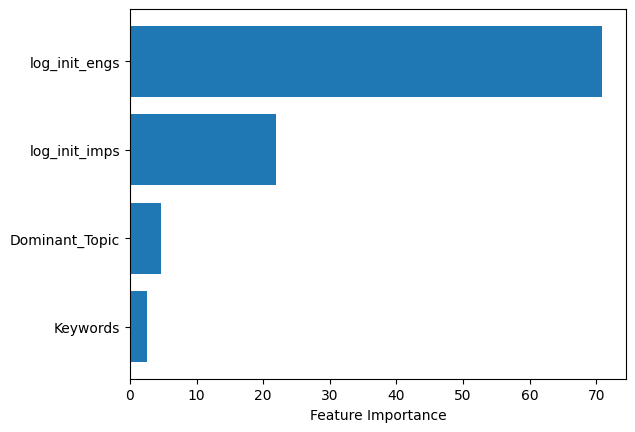

In [47]:
# Visualize Feature Importance
import matplotlib.pyplot as plt

feature_importance = best_model.get_feature_importance(type=catboost.EFstrType.FeatureImportance)
feature_names = X_train.columns

# Create a sorted index based on feature importance
sorted_idx = feature_importance.argsort()

# Plot feature importance
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

R-squared Score (Train): 0.80
R-squared Score (Test): 0.80


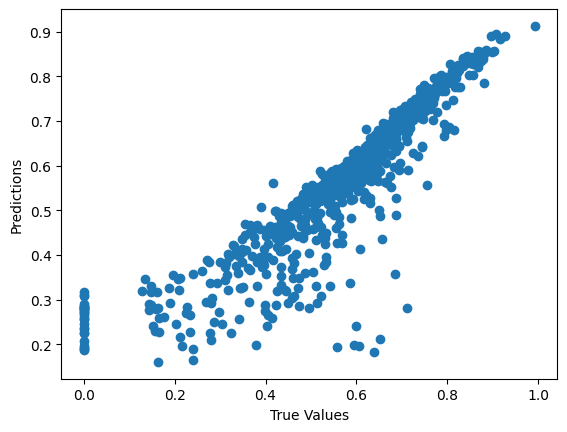

In [55]:
y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)
r_squared = r2_score(y_test, y_pred)
r_squared_train = r2_score(y_train, y_train_pred)
print(f"R-squared Score (Train): {r_squared:.2f}")
print(f"R-squared Score (Test): {r_squared:.2f}")
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [52]:
# scale the predictions back to normal and recalculate R Score
# scale back true values (y)
y_train_normal = np.exp(y_train)
y_test_normal = np.exp(y_test)

# get train/test predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# scale back predictions
y_train_pred_normal = np.exp(y_train_pred)
y_test_pred_normal = np.exp(y_test_pred)

# Assuming 'y_true' contains the true target values and 'y_pred' contains the predicted values
r_squared_train = r2_score(y_train_normal, y_train_pred_normal)
r_squared_test = r2_score(y_test_normal, y_test_pred_normal)

print(f"Train (normal) R-squared Score: {r_squared_train:.2f}")
print(f"Test (normal) R-squared Score: {r_squared_test:.2f}")

Train (normal) R-squared Score: 0.84
Test (normal) R-squared Score: 0.84
